In [3]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np

# Hilfsfunktion für Byte-Werte
def format_bytes_value(value):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if abs(value) < 1024.0:
            return f"{value:.1f} {unit}"
        value /= 1024.0
    return f"{value:.1f} PB"

# Containerliste
container_names = ["backend-a-1", "backend-b-1", "myservice"]

# Zeiträume
testraeume = {
    "L1": (datetime.strptime("2025-05-30 16:09:56", "%Y-%m-%d %H:%M:%S"), datetime.strptime("2025-05-30 16:11:17", "%Y-%m-%d %H:%M:%S")),
    "L2": (datetime.strptime("2025-05-30 15:54:25", "%Y-%m-%d %H:%M:%S"), datetime.strptime("2025-05-30 16:04:31", "%Y-%m-%d %H:%M:%S")),
    "L3": (datetime.strptime("2025-05-30 16:13:35", "%Y-%m-%d %H:%M:%S"), datetime.strptime("2025-05-30 16:58:13", "%Y-%m-%d %H:%M:%S"))
}

# Prometheus-Parameter
prometheus_url = "http://localhost:9090"
step = "10s"

# Container-Metriken
metriken = [
    {
        "name": "Durchschnittliche CPU-Auslastung",
        "query_template": 'avg_over_time(dockerstats_cpu_usage_ratio{{name="{container}"}}[5m]) * 100',
        "ylabel": "CPU-Auslastung (%)",
        "value_formatter": lambda v: f"{v:.1f} %"
    },
    {
        "name": "Durchschnittlicher RAM-Verbrauch",
        "query_template": 'avg_over_time(dockerstats_memory_usage_bytes{{name="{container}"}}[5m]) / 1024 / 1024',
        "ylabel": "RAM (MB)",
        "value_formatter": lambda v: f"{v:.1f} MB"
    },
    {
        "name": "RAM-Verbrauch (Maximum)",
        "query_template": 'max_over_time(dockerstats_memory_usage_bytes{{name="{container}"}}[5m]) / 1024 / 1024',
        "ylabel": "RAM (MB)",
        "value_formatter": lambda v: f"{v:.1f} MB"
    },
    {
        "name": "Gesamte Empfangene Bytes",
        "query_template": 'increase(dockerstats_network_received_bytes{{name="{container}"}}[1m])',
        "ylabel": "Empfangen (Bytes)",
        "value_formatter": format_bytes_value
    },
    {
        "name": "Gesamte Übertragene Bytes",
        "query_template": 'increase(dockerstats_network_transmitted_bytes{{name="{container}"}}[1m])',
        "ylabel": "Gesendet (Bytes)",
        "value_formatter": format_bytes_value
    }
]


zusatzmetriken = [
    {
        "name": "Anzahl abgefangener Fehler (retry)",
        "query": 'sum by (instance) (increase(retry_failures_total{uri="/call-a-unstable"}[10m]))',
        "ylabel": "Fehleranzahl",
        "formatter": lambda v: f"{v:.0f}"
    },
    {
        "name": "Fehlerrate in % (retry)",
        "query": '''
        100 *
        sum(increase(retry_failures_total{uri="/call-a-unstable"}[10m]))
        /
        (
          sum(increase(http_server_requests_seconds_count{uri="/call-a-unstable"}[10m]))
          + sum(increase(retry_failures_total{uri="/call-a-unstable"}[10m]))
        )
        ''',
        "ylabel": "Fehlerrate (%)",
        "formatter": lambda v: f"{v:.1f} %"
    },
    {
        "name": "Erfolgsquote unter Berücksichtigung von Retries",
        "query": '''
        100 *
        sum(increase(http_server_requests_seconds_count{uri="/call-a-unstable", status=~"2.."}[10m]))
        /
        (
          sum(increase(http_server_requests_seconds_count{uri="/call-a-unstable"}[10m]))
          + sum(increase(retry_failures_total{uri="/call-a-unstable"}[10m]))
        )
        ''',
        "ylabel": "Erfolgsquote (%)",
        "formatter": lambda v: f"{v:.1f} %"
    },
    {
        "name": "Durchschnittliche Reaktionszeit im Testzeitraum",
        "query": '''
        sum by (uri) (rate(http_client_reaktionszeit_seconds_sum[10s]))
        /
        sum by (uri) (rate(http_client_reaktionszeit_seconds_count[10s]))
        ''',
        "ylabel": "Ø Reaktionszeit (s)",
        "formatter": lambda v: f"{v:.3f} s"
    },
    {
        "name": "95. Perzentil der Reaktionszeit im Testzeitraum",
        "query": '''
        histogram_quantile(0.95, sum(rate(http_client_reaktionszeit_seconds_bucket[10s])) by (uri, le))
        ''',
        "ylabel": "95. Perzentil (s)",
        "formatter": lambda v: f"{v:.3f} s"
    },
    {
        "name": "Maximale Antwortzeit im Testzeitraum",
        "query": 'max(http_client_reaktionszeit_seconds_max{job="myservice"}) by (uri)',
        "ylabel": "Max. Antwortzeit (s)",
        "formatter": lambda v: f"{v:.3f} s"
    }
]


# Ergebnisse sammeln
all_results = []

# Container-Metriken auswerten
for metric in metriken:
    for laststufe, (start_dt, end_dt) in testraeume.items():
        start = int(start_dt.timestamp())
        end = int(end_dt.timestamp())
        for container in container_names:
            query = metric["query_template"].format(container=container)
            response = requests.get(f"{prometheus_url}/api/v1/query_range", params={
                "query": query,
                "start": start,
                "end": end,
                "step": step
            })
            data = response.json()
            if (
                data["status"] == "success"
                and data["data"]["result"]
                and data["data"]["result"][0]["values"]
            ):
                values = [float(v[1]) for v in data["data"]["result"][0]["values"]]
                mean_val = np.mean(values)
                formatted_val = metric["value_formatter"](mean_val)
            else:
                formatted_val = "keine Daten"
            all_results.append({
                "Laststufe": laststufe,
                "Gruppe": container,
                "Metrik": metric["name"],
                "Wert": formatted_val
            })

# Globale Metriken auswerten
for z_metric in zusatzmetriken:
    for laststufe, (start_dt, end_dt) in testraeume.items():
        start = int(start_dt.timestamp())
        end = int(end_dt.timestamp())
        response = requests.get(f"{prometheus_url}/api/v1/query_range", params={
            "query": z_metric["query"],
            "start": start,
            "end": end,
            "step": step
        })
        data = response.json()
        if data["status"] == "success" and data["data"]["result"]:
            for serie in data["data"]["result"]:
                label = serie["metric"].get("instance") or serie["metric"].get("uri") or "unbekannt"
                values = [float(v[1]) for v in serie["values"] if v[1] != "NaN"]
                if values:
                    avg_value = np.mean(values)
                    formatted_val = z_metric["formatter"](avg_value)
                else:
                    formatted_val = "keine Daten"
                all_results.append({
                    "Laststufe": laststufe,
                    "Gruppe": label,
                    "Metrik": z_metric["name"],
                    "Wert": formatted_val
                })
        else:
            all_results.append({
                "Laststufe": laststufe,
                "Gruppe": "unbekannt",
                "Metrik": z_metric["name"],
                "Wert": "keine Daten"
            })

# DataFrame erzeugen
df_final = pd.DataFrame(all_results)

# Metriken trennen
reaktionszeit_metriken = [
    "Durchschnittliche Reaktionszeit im Testzeitraum",
    "95. Perzentil der Reaktionszeit im Testzeitraum",
    "Maximale Antwortzeit im Testzeitraum"
]

df_reaktionszeit = df_final[df_final["Metrik"].isin(reaktionszeit_metriken)]
df_rest = df_final[~df_final["Metrik"].isin(reaktionszeit_metriken)]

# Ausgabe
print("\nGesamttabelle aller Metriken:")
print(df_final.to_string(index=False))

# CSV-Dateien schreiben
df_reaktionszeit.to_csv("metriken_reaktionszeit.csv", index=False)
df_rest.to_csv("metriken_rest.csv", index=False)

print("\nErgebnisse wurden gespeichert unter:")
print(" - metriken_reaktionszeit.csv")
print(" - metriken_rest.csv")



Gesamttabelle aller Metriken:
Laststufe         Gruppe                                          Metrik     Wert
       L1    backend-a-1                Durchschnittliche CPU-Auslastung 2217.1 %
       L1    backend-b-1                Durchschnittliche CPU-Auslastung   68.2 %
       L1      myservice                Durchschnittliche CPU-Auslastung 2070.5 %
       L2    backend-a-1                Durchschnittliche CPU-Auslastung 1494.9 %
       L2    backend-b-1                Durchschnittliche CPU-Auslastung 1341.0 %
       L2      myservice                Durchschnittliche CPU-Auslastung 1603.9 %
       L3    backend-a-1                Durchschnittliche CPU-Auslastung  303.6 %
       L3    backend-b-1                Durchschnittliche CPU-Auslastung  224.0 %
       L3      myservice                Durchschnittliche CPU-Auslastung  406.5 %
       L1    backend-a-1                Durchschnittlicher RAM-Verbrauch 254.3 MB
       L1    backend-b-1                Durchschnittlicher RAM-Verb

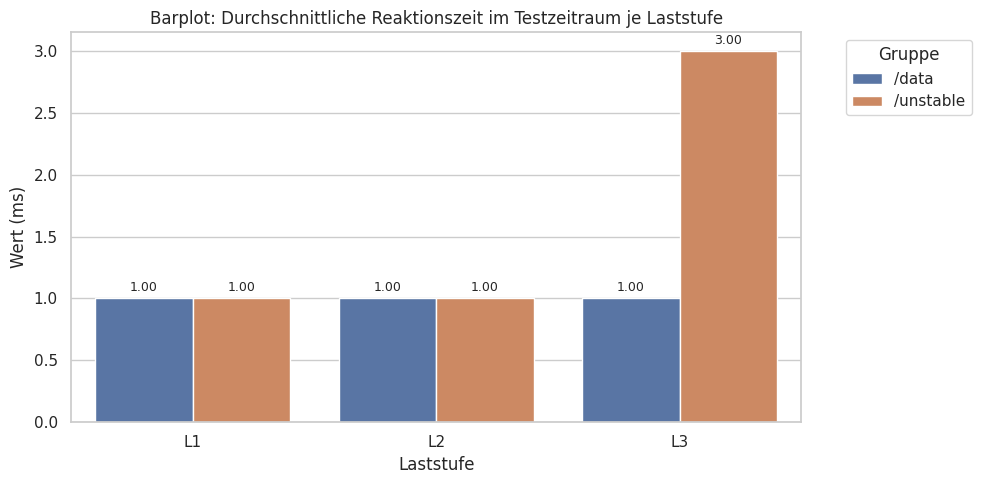

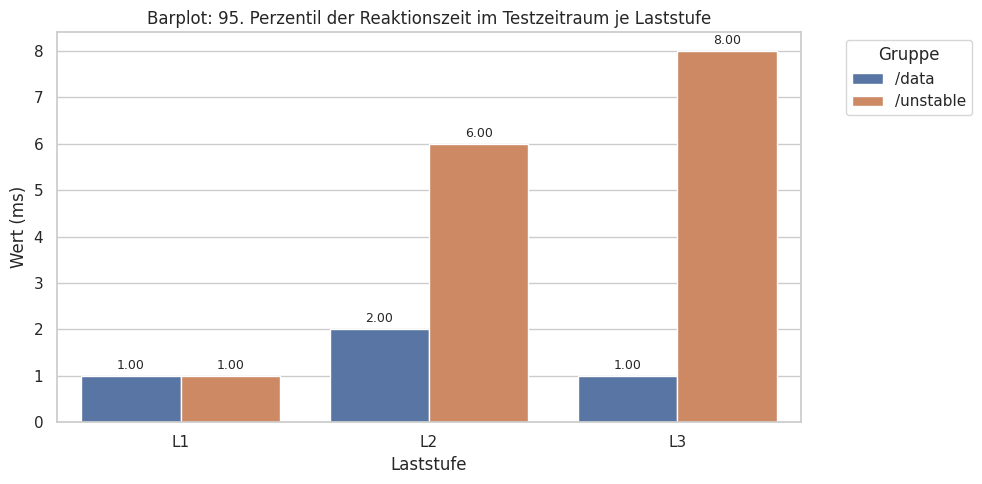

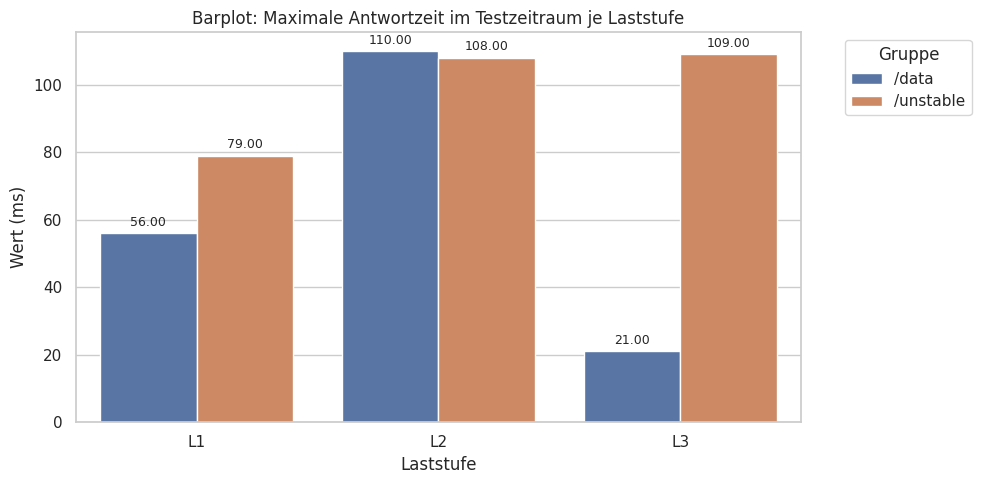

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV laden
df = pd.read_csv("metriken_reaktionszeit.csv")

# Einheit und numerischen Wert extrahieren
def extract_numeric_and_unit(wert_str):
    try:
        parts = wert_str.strip().split()
        if len(parts) == 2:
            number = float(parts[0].replace(",", "."))
            unit = parts[1]
            return number, unit
        else:
            return None, ""
    except:
        return None, ""

# Neue Spalten erzeugen
df[["Wert_Numerisch", "Einheit"]] = df["Wert"].apply(lambda x: pd.Series(extract_numeric_and_unit(str(x))))

# Skalierungslogik
def get_scaling(einheit):
    einheit = einheit.strip()
    if einheit == "s":
        return "ms", 1000  # s → ms
    elif einheit == "ms":
        return "ms", 1
    elif einheit == "µs":
        return "µs", 1
    else:
        return einheit, 1  # Standardfall

# Plotstil
sns.set(style="whitegrid")

# Plots für alle Metriken
for metric in df["Metrik"].unique():
    plot_df = df[(df["Metrik"] == metric) & (df["Wert_Numerisch"].notna())].copy()
    if plot_df.empty:
        continue

    # Einheit bestimmen
    häufigste_einheit = plot_df["Einheit"].mode()[0]
    y_einheit, faktor = get_scaling(häufigste_einheit)

    # Umrechnen
    plot_df["Wert_umgerechnet"] = plot_df["Wert_Numerisch"] * faktor

    # Plot
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x="Laststufe", y="Wert_umgerechnet", hue="Gruppe", data=plot_df)

    # Balkenbeschriftung
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=9, label_type="edge", padding=3)

    # Beschriftung
    plt.title(f"Barplot: {metric} je Laststufe")
    plt.ylabel(f"Wert ({y_einheit})")
    plt.xlabel("Laststufe")
    plt.legend(title="Gruppe", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


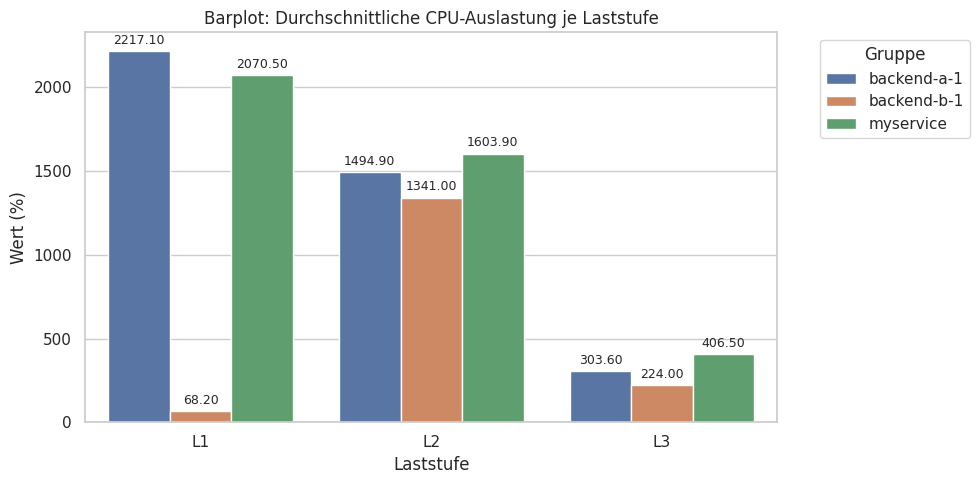

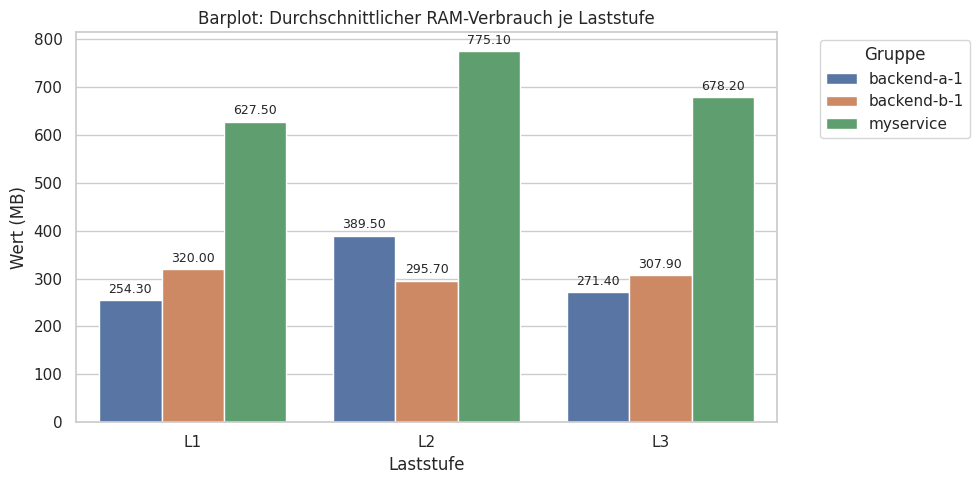

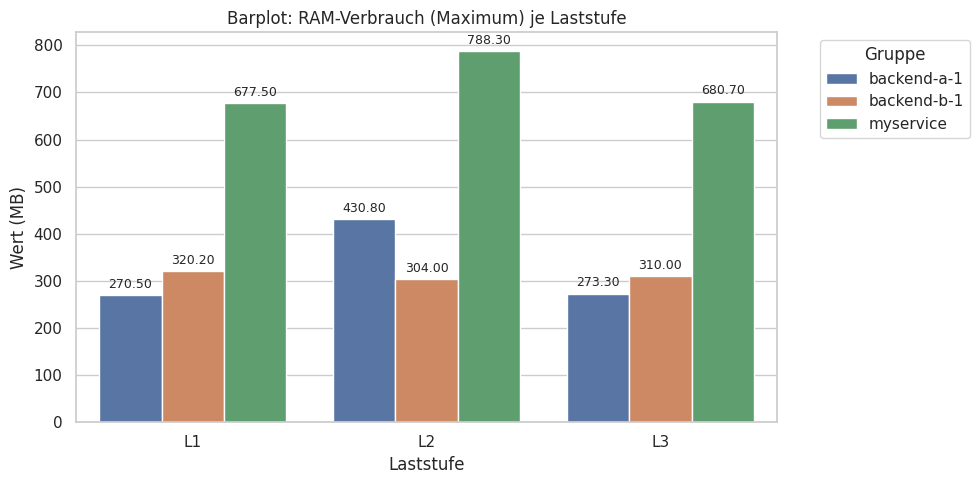

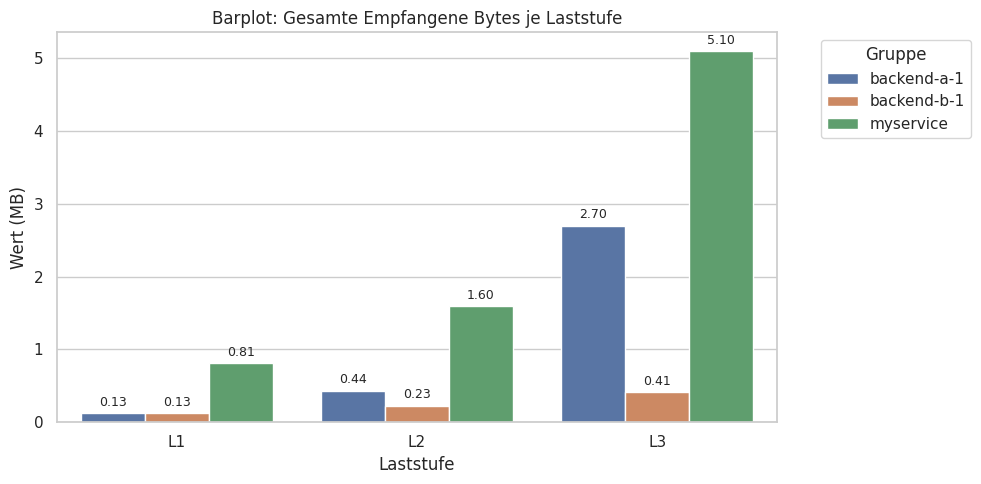

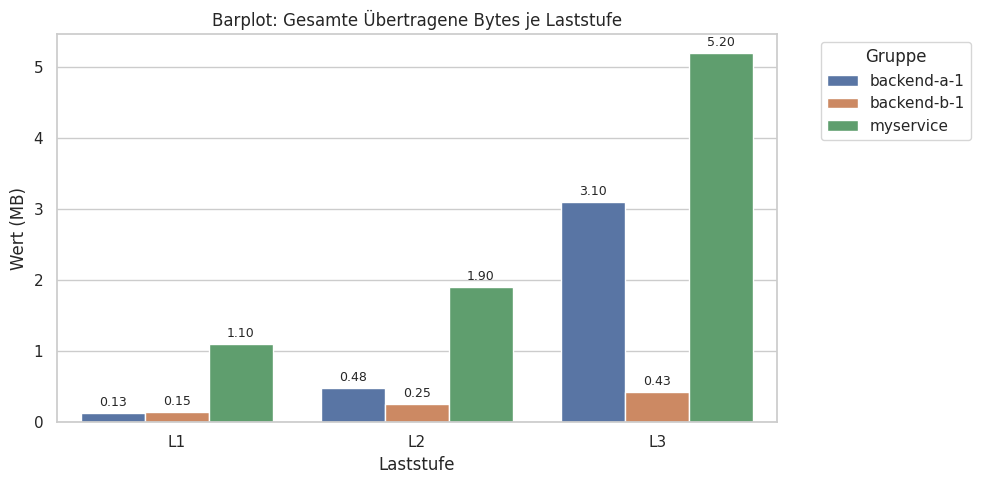

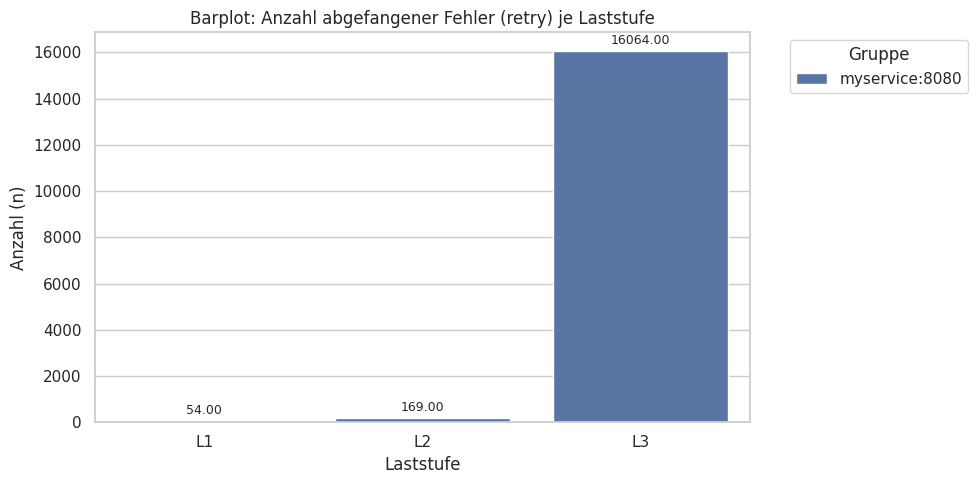

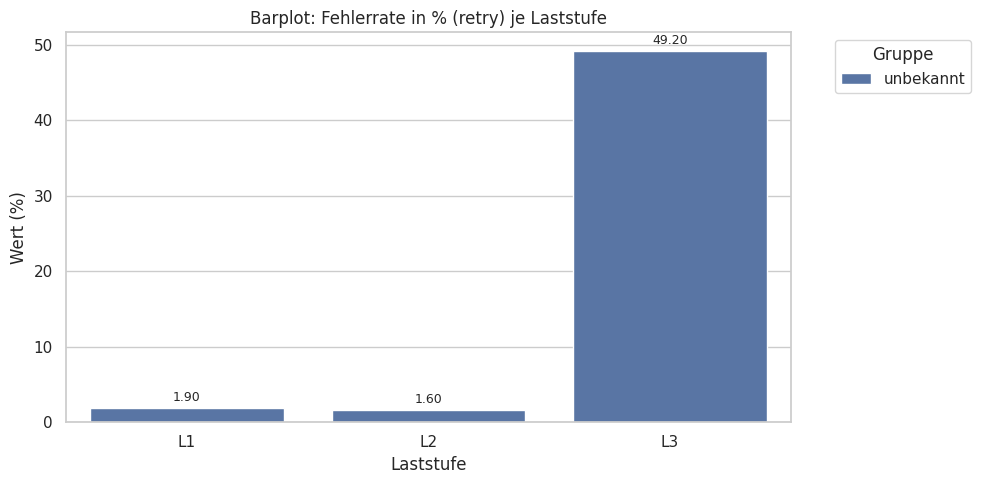

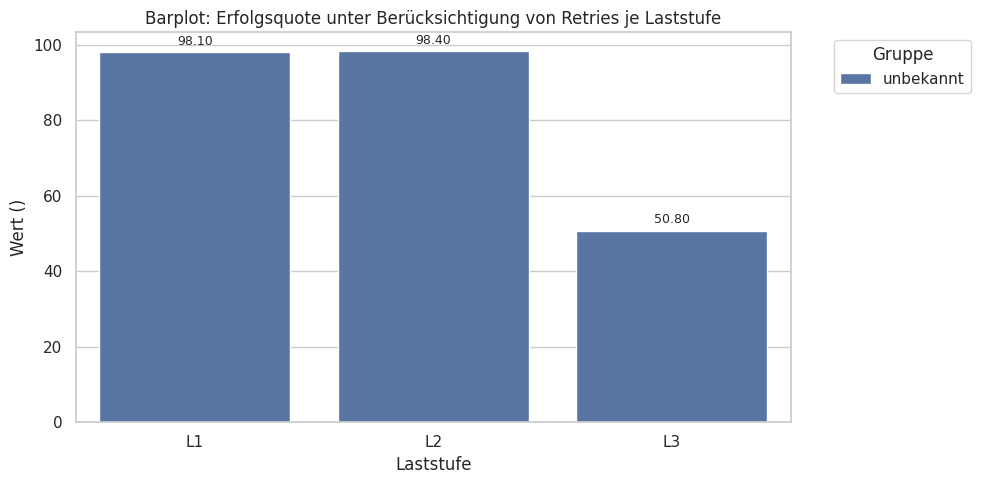

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV laden
df = pd.read_csv("metriken_rest.csv")

# "keine Daten" zu 0 setzen
df["Wert"] = df["Wert"].replace("keine Daten", "0")

# Funktion zur Extraktion von Zahl und Einheit
def extract_numeric_and_unit(wert_str):
    try:
        wert_str = wert_str.strip()
        parts = wert_str.split()
        if len(parts) == 2:
            number = float(parts[0].replace(",", "."))
            unit = parts[1]
            return number, unit
        elif len(parts) == 1:
            return float(parts[0].replace(",", ".")), ""
        else:
            return None, ""
    except:
        return None, ""

# Neue Spalten erzeugen
df[["Wert_Numerisch", "Einheit"]] = df["Wert"].apply(lambda x: pd.Series(extract_numeric_and_unit(str(x))))

# Umrechnungsfaktoren
byte_factors = {
    "B": 1,
    "KB": 1024,
    "MB": 1024 ** 2,
    "GB": 1024 ** 3
}

time_factors = {
    "s": 1,
    "ms": 1 / 1000,
    "µs": 1 / 1_000_000
}

# Einheitentyp erkennen
def detect_type(metric):
    metric = metric.lower()
    if "bytes" in metric or "ram" in metric:
        return "Bytes"
    elif "%" in metric or "cpu" in metric or "verfügbarkeit" in metric:
        return "%"
    elif "zeit" in metric or "s)" in metric:
        return "Zeit"
    elif "anzahl" in metric or "zähler" in metric or "fehler" in metric:
        return "Anzahl"
    else:
        return "?"

# Umrechnung auf Basis-Einheit
def to_base_unit(wert, einheit, typ):
    einheit = einheit.strip()
    if pd.isna(wert):
        return None
    if typ == "Bytes":
        return wert * byte_factors.get(einheit, 1)
    elif typ == "Zeit":
        return wert * time_factors.get(einheit, 1)
    else:
        return wert

# Ziel-Einheit bestimmen
def get_dominant_unit(einheiten, typ):
    if typ == "Bytes":
        rangfolge = ["B", "KB", "MB", "GB"]
        for e in reversed(rangfolge):
            if e in einheiten:
                return e
    elif typ == "Zeit":
        rangfolge = ["µs", "ms", "s"]
        for e in reversed(rangfolge):
            if e in einheiten:
                return e
    elif typ == "%":
        return "%"
    elif typ == "Anzahl":
        return "n"
    else:
        return ""

# Rückkonvertierung in Ziel-Einheit
def from_base_unit(wert, ziel_einheit, typ):
    if pd.isna(wert):
        return None
    if typ == "Bytes":
        return wert / byte_factors[ziel_einheit]
    elif typ == "Zeit":
        return wert / time_factors[ziel_einheit]
    else:
        return wert

# Plotstil
sns.set(style="whitegrid")

# Plots für alle Metriken
for metric in df["Metrik"].unique():
    plot_df = df[(df["Metrik"] == metric) & (df["Wert_Numerisch"].notna())].copy()
    if plot_df.empty:
        continue

    typ = detect_type(metric)
    plot_df["Basiswert"] = plot_df.apply(lambda row: to_base_unit(row["Wert_Numerisch"], row["Einheit"], typ), axis=1)

    einheiten_set = set(plot_df["Einheit"].dropna().unique())
    ziel_einheit = get_dominant_unit(einheiten_set, typ)

    plot_df["Wert_umgerechnet"] = plot_df["Basiswert"].apply(lambda w: from_base_unit(w, ziel_einheit, typ))

    # Plot erzeugen
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x="Laststufe", y="Wert_umgerechnet", hue="Gruppe", data=plot_df)

    # Balkenbeschriftung
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=9, label_type="edge", padding=3)

    # Titel und Achsen
    plt.title(f"Barplot: {metric} je Laststufe")
    ylabel = "Wert"
    if typ == "Bytes":
        ylabel = f"Wert ({ziel_einheit})"
    elif typ == "Zeit":
        ylabel = f"Wert ({ziel_einheit})"
    elif typ == "%":
        ylabel = "Wert (%)"
    elif typ == "Anzahl":
        ylabel = "Anzahl (n)"
    else:
        ylabel = f"Wert ({ziel_einheit})"

    plt.ylabel(ylabel)
    plt.xlabel("Laststufe")
    plt.legend(title="Gruppe", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
